# Дисклеймер
Эту тетрадку лучше запускать в колабе или в vast.ai. Не мучатесь с установкой библиотек и с обучением на cpu.

In [3]:
!pip install pandas scikit-learn gensim matplotlib

     |████████████████████████████████| 9.7 MB 14.9 MB/s eta 0:00:01     |███████████████▎                | 4.6 MB 14.9 MB/s eta 0:00:01███████████████████████▉      | 7.8 MB 14.9 MB/s eta 0:00:01
     |████████████████████████████████| 24.9 MB 18.1 MB/s eta 0:00:01
     |████████████████████████████████| 23.9 MB 100.6 MB/s eta 0:00:01                      | 2.0 MB 100.6 MB/s eta 0:00:01
     |████████████████████████████████| 10.3 MB 20.1 MB/s eta 0:00:01    |███████▌                        | 2.4 MB 20.1 MB/s eta 0:00:01
     |████████████████████████████████| 303 kB 66.9 MB/s eta 0:00:01
     |████████████████████████████████| 27.2 MB 21.3 MB/s eta 0:00:01�██████████████████         | 19.5 MB 21.3 MB/s eta 0:00:01
     |████████████████████████████████| 56 kB 5.5 MB/s  eta 0:00:01
     |████████████████████████████████| 1.2 MB 67.0 MB/s eta 0:00:01


## Введение в нейронные сети 

Все задачи, которые мы решали до этого, можно решать с помощью нейронных сетей. Часто нейронные сети будут наилучшим выбором, особенно когда у нас текстовые или картиночные данные и их достаточно много (примерно от 50к). Но в любом случае, перед тем как доставать нейронки лучше прогнать несколько стандартных моделей. Часто они решат задачу на приемлимом уровне и время, затраченное на обучение нейронки, не окупит себя. Также с табличными данными лучше просто использовать бустинги.

Для написания нейронок есть два основных фреймворка -  tensorflow и pytorch. Сказать, что лучше, тяжело. В целом, тензорфлоу с встроенным keras (раньше был отдельным фреймворком) сильно проще для новичков, но многое в нём происходит "под капотом". Когда все работает это даже хорошо, но когда что-то ломается, очень сложно понять, что именно.  Pytorch сложнее в освоении и многие вещи там приходится делать вручную, но это заставляет разобраться в технических деталях и дает большую свободу. 


В этой тетрадке код написан на торче

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Для наглядности возьмем две разные задачи - классификации и регресии. В обоих задачах мы будем работать с текстом и по большей части весь пайплайн у нас будет одинаков. Отличаться будут только последние штрихи в самих моделях.

## Регрессия на данных Avito

Данные из соревнования - https://www.kaggle.com/c/avito-demand-prediction/overview  
Я взял только поле description, так как наша задача разобраться с нейронками, а не добиться самого большого качества.

In [3]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

Во всех предыдущих семинарах мы обрезали данные Авито, так как модели не могли столько переварить. В случае нейронок такой проблемы нет, модель обучается на батчах (кусках данных) и можно использовать неограниченное количество данных. Но такие большие датасеты лучше не грузить в память целиком и генерировать по необходимости.

Чтобы разобрать предобработку пока возьмем 10% от данных, а позже напишем логику генерации.

In [4]:
avito = pd.read_csv('avito_data.csv').dropna().sample(frac=0.1)

In [5]:
avito.shape

(138715, 2)

Предобработка достаточно простая. Главное - получить из текстов токены.

In [10]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

Теперь нам нужно собрать все уникальные слова в словарь. Лучше сразу посчитать количество упоминаний, чтобы отсеять самые редкие.

In [11]:
vocab = Counter()

for text in avito.description:
    vocab.update(preprocess(text))

почти 300к слов - это много, учитывая, что это только 10% данных

In [12]:
len(vocab)

1429855

Возьмем только те, что встретились больше 30 раз.

In [13]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

11к - уже нормальная цифра

In [14]:
len(filtered_vocab)

54266

Теперь нам нужно заменить в каждом тексте слова на числа (индексы в словаре). 

Создадим для этого специальный словарь с индексами. В этот словарь нам нужно положить дополнительный токен - PAD (чуть ниже станет понятнее)

In [15]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

В нашей задаче нам не понадобится раскодировать индексы, но если бы мы делали языковую модель, нам бы понадобился ещё и обратный словарь.

In [16]:
id2word = {i:word for word, i in word2id.items()}

А теперь про паддинг. 

Все тексты в нашем трейне разной длины и это проблема, так как модель ожидает последовательности одной длины. Для этого есть паддинг - т.е. забивание последовательности нулями до определенной длинны (мы не просто так присвоили PAD нулевой индекс - это важно)

Лучше всего сделать паддиг до самого длинного текста, но это зачастую не оптимально или даже невозможно из-за нехватки ресурсов. Поэтому значение паддинга приходится подбирать на глаз. 



In [17]:
MAX_LEN = 0

for text in avito.description:
    tokens = preprocess(text)
    MAX_LEN = max(len(tokens), MAX_LEN)


In [18]:
MAX_LEN # реальная максимальная длина

711

Значение в 100 кажется адекватным 

In [19]:
MAX_LEN = 100

Паддинг в торче устроен немного по-другому (по сравнении с tf). Воспроизвести такой-же результат как и в tf можно двумя способами. 

### Паддинг каждого в отдельности

In [15]:

X = torch.LongTensor(size=(avito.shape[0], 100))

for i, text in enumerate(avito.description):
    tokens = preprocess(text) # токенизируем
    
    ids = [word2id[token] for token in tokens if token in word2id][:MAX_LEN] # заменяем токены на индексы в словаре
                                                                             # и сразу обрезаем если > MAX_LEN
    
    # паддим до 100 справа
    # нужно каждый раз указывать сколько 0 добавлять
    # для этого вычитаем из 100 длину текущего текста
    # 
    ids = torch.nn.functional.pad(torch.LongTensor(ids), 
                            (0, MAX_LEN-len(ids)), # можно задать паттерн паддинга туплом - 
                                                           #  (паддинг слева, паддинг справа); 
                                                           # еще можно задать паддинг с 4-х сторон - 
                                                           # (слева, справа, сверху, снизу)
                            mode='constant', # еще можно по-другому паддить (не нулями), об этом на следующем занятии
                            value=0)
    X[i] = ids

In [16]:
X.size() # в торче не shape а size

torch.Size([138715, 100])

### Паддинг сразу всех и обрезание

In [17]:
X = []

for text in avito.description:
    tokens = preprocess(text) # токенизируем
    ids = torch.LongTensor([word2id[token] for token in tokens if token in word2id]) # заменяем токены на индексы
                                                                                     # переводим в тензор
    X.append(ids)

In [18]:
X = torch.nn.utils.rnn.pad_sequence(X, batch_first=True) # паддим все до максимальной длины

In [19]:
X.size() # значение отличается от MAX_LEN выше из-за того, что не все слова есть в словаре

torch.Size([138715, 456])

In [20]:
X = X[:, :MAX_LEN] # обрезаем до нужной длины

In [21]:
X.size()

torch.Size([138715, 100])

Чтобы итерироваться по данным нужно создать вот такой класс, в котором будет функция \_\_get_item\_\_

В нее будет передавать индекс и мы можем задать вручную, что по этому индексу будет возвращаться  

В этот класс мы вставим предобработку, которую делали выше. Так мы сможем генерировать данные батчами и не грузить все целиком.

In [20]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, dataset, word2id, MAX_LEN, text_field, target_field):
        
        # храним сырой датасет
        # еще лучше можно сделать, если считывать из файла при генерации
        self.dataset = dataset[text_field].values
        
        # мы не считаем словарь прямо тут, т.к. нам нужно шерить словарь между трейном и валидацией
        self.word2id = word2id
        self.MAX_LEN = MAX_LEN
        self.length = dataset.shape[0]
        # таргеты можно сразу целиком выделить 
        self.target = torch.Tensor(dataset[target_field].values)

    def __len__(self):
        # нужно уметь возвращать длину датасета, в нашем случае это просто сделать
        # если не загружать данные целиком, а читать из файла - это может быть сложнее
        return self.length

    def __getitem__(self, index):

        # в index будут индексы от 0 до self.length
        # по ним мы достанем тексты, предобработаем,переведем в векторы, западим и вернем


        tokens = self.preprocess(self.dataset[index]) # токенизируем
        ids = [self.word2id[token] for token in tokens if token in self.word2id][:MAX_LEN]
        ids = torch.nn.functional.pad(torch.LongTensor(ids), 
                                (0, self.MAX_LEN-len(ids)), 
                                mode='constant',
                                value=0)

        y = self.target[index]

        return ids, y
    
    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens


In [21]:
avito = pd.read_csv('avito_data.csv').dropna() # берем все данные
train_dataset, valid_dataset = train_test_split(avito, test_size=0.05)

In [22]:
training_set = Dataset(train_dataset, word2id, MAX_LEN, 'description', 'deal_probability')
training_generator = torch.utils.data.DataLoader(training_set, batch_size=256)

In [23]:
valid_set = Dataset(valid_dataset, word2id, MAX_LEN, 'description', 'deal_probability')
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=256)

Теперь нужно прописать логику обучения. Этот момент в tf и torch отличается наверное заментнее всего.

In [24]:
# функция для трейна
# логика такая:  1) достаем батч данных, 
#              2) прогоняем через модель 
#              3) считаем функцию потерь
#              4) считаем и сохраняем градиенты 
#              5) обновляем параметры модели 

def train(model, iterator, optimizer, criterion, print_every=1000):
    epoch_loss = 0 # тут будет хранить лосс на каждом батче, чтобы потом посчитать средний лосс по эпохе
    model.train()  # в торче нужно указать, что сейчас мы обучаемся и нужно хранить градиенты для апдейта модели

    for i, (texts, ys) in enumerate(iterator):
        
        # в торче нужно явно обнулять градиенты
        # если этого не сделать, то градиенты будут накапливаться со всех батчей
        # а нам нужно чтобы каждый батч рассматривался в отдельности
        # эта функция может пригодиться если данные помещаются очень маленькими батчами или вообще по 1
        # так можно накопить градиенты и сделать апдейт после нескольких прогонов через модель и только потом обнулиться 
        optimizer.zero_grad()   
        
        # прогоняем тексты через модель
        predictions = model(texts.to(device)).squeeze()  
        
        # считаем лосс
        loss = criterion(predictions.float(), ys.to(device).float())        
        
        # градиенты
        loss.backward()     
        
        # обновляем модель 
        optimizer.step()      
        
        # сохраняем значение лосса
        epoch_loss += loss.item() 
        
        # можно вставить промежуточные принты, чтобы понимать что происходит
        if not (i+1) % print_every:
            print(f'Loss: {epoch_loss/i}')
        
    return epoch_loss / len(iterator) # возвращаем усредненное значение лосса по всем батчам

In [25]:
# функция для валидации отличается тем, что мы не считаем градиенты и не обновляем модель

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()  # режим валидации (нужно если в модели есть Dropout )

    with torch.no_grad(): # не считаем градиенты
        for texts, ys in iterator:   

            predictions = model(texts.to(device)).squeeze()  # прогоняем тексты
            loss = criterion(predictions.float(), ys.to(device).float())   # считаем лосс  

            # сохраняем лосс
            epoch_loss += loss.item()  
        
    return epoch_loss / len(iterator) # возвращаем средний лосс

Теперь создаем модель

In [26]:
class Regression(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, output_dim):
        
        super().__init__()          
        
        # Создаем слои и указываем параметры
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim) # то же самое что Dense в tf keras
        self.act = nn.Sigmoid() # активация отдельно, мы предсказываем число, поэтому можно было и не ставить активацию
                                # но наш таргет от 0 до 1, поэтому и предсказания лучше ограничить
                                # сигмоида - как раз функция, которая маппит число в интервал от 0 до 1
        
        
    def forward(self, text):
        # описываем как данные проходят по слоям
        embedded = self.embedding(text)   # эмбедим тексты
        hidden = torch.mean(embedded, dim=1) # усредняем вектора последовательности
        dense_outputs=self.fc(hidden) # пропускаем через полносвязный слой 

        # применяем активацию, чтобы получить предикт в нужном интервале
        outputs=self.act(dense_outputs)
        
        return outputs

Создаем оптимайзер и класс для лосса  
Инициализируем модель и отправляем ее на gpu (это нужно делать вручную, обратите внимание, что выше в функциях train  и evaluate данные также отправляются на видеокарту вручную, данные и модель должны быть в одном месте - либо на gpu либо на cpu)

In [27]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Regression(len(word2id), 30, 1)


optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss() # лосс для регрессии - mse (mean squared error)

# отправляем модель и класс лосса на гпу
model = model.to(device)
criterion = criterion.to(device)

Запускаем обучение

In [28]:
losses = []
losses_eval = []

for i in range(3):
    print(i)
    losses.append(train(model, training_generator, optimizer, criterion))
    losses_eval.append(evaluate(model, valid_generator, criterion))

0
Loss: 0.06477599534708578
Loss: 0.06260758320083017
Loss: 0.06176662701453794
Loss: 0.061212924311170876
Loss: 0.060750814953233555
1
Loss: 0.057957255166840624
Loss: 0.057846035528788274
Loss: 0.0579212444557095
Loss: 0.057922998638406754
Loss: 0.05783559635555799
2
Loss: 0.056886465423875626
Loss: 0.05681015573080448
Loss: 0.0569264260979345
Loss: 0.05696758405622407
Loss: 0.05687612739778574


Хороший график должен выглядеть как-то так (и трейн и валидация снижаются, между ними нет слишком сильной разницы), но разница между начальными и конечными числами могла бы быть побольше.

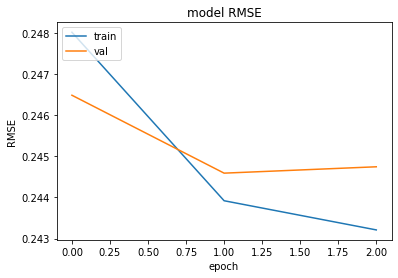

In [35]:
# Нарисуем график с RMSE (это просто корень из лосса)
plt.plot(np.sqrt(losses))
plt.plot(np.sqrt(losses_eval))
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Обучать эмбединги под задачу в теории правильнее всего, но на практике бывает лучше использовать предобученные эмбединги (word2vec, fastext, glove). Отдельно эмбединги обучаются быстрее и можно использовать гораздо больше данных, так как нам не нужна разметка.

Обучим фастекст модель.

In [25]:
import gensim

/opt/conda/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [23]:
texts = avito.sample(frac=0.1).description.apply(preprocess).tolist()

In [26]:
%%time
ft = gensim.models.FastText(texts, vector_size=100, epochs=5)

CPU times: user 4min 11s, sys: 7.05 s, total: 4min 18s
Wall time: 1min 41s


In [27]:
ft.wv.most_similar('коляска')

[('коляска-люлька', 0.9760681390762329),
 ('кресло-коляска', 0.9455839395523071),
 ('санки-коляска', 0.9428970813751221),
 ('колясочка', 0.937743604183197),
 ('коляску,в', 0.9363677501678467),
 ('колясках', 0.9245208501815796),
 ('коляска-трансформер', 0.9208803176879883),
 ('аляска', 0.9043774604797363),
 ('кoляска', 0.8985717296600342),
 ('коляску-трансформер', 0.8910782337188721)]

Теперь нам нужно сделать матрицу с векторами. Индексы строчек в этой матрице должны совпадать с индексами слов в словаре.

In [29]:
weights = np.zeros((len(word2id), 100))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue
    
    try:
        weights[i] = ft.wv[word]
    
    
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        weights[i] = ft.wv['опрагпллирао']

In [30]:
class Regression_Emb(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, embeddings_weights, output_dim):
        
        super().__init__()          
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # вот так можно загрузить готовые вектора и заморозить обучение
        self.embedding.from_pretrained(torch.tensor(embeddings_weights), freeze=True)
        self.fc = nn.Linear(embedding_dim, output_dim)
        self.act = nn.Sigmoid()
        
    def forward(self, text):
        embedded = self.embedding(text)   
        hidden = torch.mean(embedded, dim=1)
        dense_outputs=self.fc(hidden)
        outputs=self.act(dense_outputs)
        
        return outputs

In [32]:
# в остальном все также
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Regression_Emb(len(word2id), 100, weights, 1)

optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()


model = model.to(device)
criterion = criterion.to(device)

In [33]:
losses = []
losses_eval = []
for i in range(3):
    print(i)
    losses.append(train(model, training_generator, optimizer, criterion))
    losses_eval.append(evaluate(model, valid_generator, criterion))

0
Loss: 0.07252339075680252
Loss: 0.06893570427449719
Loss: 0.06691501865603798
Loss: 0.0655519172789589
Loss: 0.06463247046372395
1
Loss: 0.06081590337214527
Loss: 0.060488868683666035
Loss: 0.060373216442622196
Loss: 0.060233215822610715
Loss: 0.060133176877167634
2
Loss: 0.05988390226517473
Loss: 0.05963499575905528
Loss: 0.05958813311741447
Loss: 0.05951087957256942
Loss: 0.05946526806305995


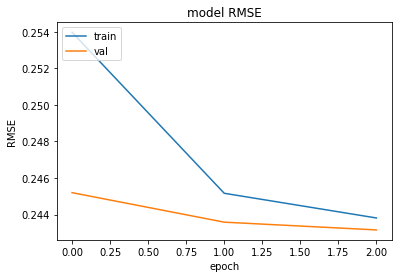

In [34]:
plt.plot(np.sqrt(losses))
plt.plot(np.sqrt(losses_eval))
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Классификация

Теперь проделаем тоже самое с классификацией. 

Данные возьмем из соревнования - https://www.kaggle.com/c/quora-insincere-questions-classification/overview  
В этом соревновании нужно было предсказывать токсичность вопроса.

In [29]:
quora = pd.read_csv('quora.csv')

In [30]:
quora

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
...,...,...,...
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0


Предобработка точно такая же

In [31]:
# словарь
vocab = Counter()

for text in quora.question_text:
    vocab.update(preprocess(text))

In [32]:
len(vocab)

273056

In [33]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 50:
        filtered_vocab.add(word)

In [34]:
len(filtered_vocab)

14083

In [35]:
# индексируем слова
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [36]:
id2word = {i:word for word, i in word2id.items()}

In [37]:
# поставит тоже 100
MAX_LEN = 100

In [38]:
train_dataset, valid_dataset = train_test_split(quora, test_size=0.05)

Разлчия в самой модели тоже минимальные - нужно поменять активацию в последнем слое, лосс и можно добавить метрику.

In [39]:
training_set = Dataset(train_dataset, word2id, MAX_LEN, 'question_text', 'target')
training_generator = torch.utils.data.DataLoader(training_set, batch_size=256)

valid_set = Dataset(valid_dataset, word2id, MAX_LEN, 'question_text', 'target')
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=256)

Как выбирать batch_size? Размер батча может влиять на качество модели и точно влияет на скорость обучения. Обычно, чем больше батч, тем быстрее будет обучаться модель. Размер батча ограничен памятью видеокарты, поэтому чем лучше gpu, тем больше может быть batch_size. 

Примерное максимальное значение можно найти быстрым перебором. Если появляется ошибка, то слишком большой batch_size, а если обучается, то можно попробовать поставить побольше.

In [40]:
class Clf(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, output_dim):
        
        super().__init__()          
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.flatten = nn.Flatten() # вместо усреднения склеим все в 1 вектор
        self.fc = nn.Linear(embedding_dim*MAX_LEN, output_dim) # размер склееного вектора - размер эмбединга на MAX_LEN
        self.act = nn.Sigmoid() # активацию менять даже не пришлось, так как у нас бинарная классификация
                                # если классов больше 2, то нужно поставить nn.Softmax()
        
    def forward(self, text):
        
        embedded = self.embedding(text)   
        hidden = self.flatten(embedded)
        dense_outputs=self.fc(hidden)
        outputs=self.act(dense_outputs)
        
        return outputs

Немного перепишем функции тренировки и обучения, чтобы еще и accuracy посчитать

In [41]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc


def train(model, iterator, optimizer, criterion, print_every=1000):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()  

    for i, (texts, ys) in enumerate(iterator):
        
        optimizer.zero_grad()   
        predictions = model(texts.to(device)).squeeze()  
        loss = criterion(predictions.float(), ys.to(device).float())        
        acc = binary_accuracy(predictions.float(), ys.to(device).float())
        loss.backward()     
        
        optimizer.step()      
        
        #лосс и еще и метрика теперь
        epoch_loss += loss.item()  
        epoch_acc += acc.item()
        
        if not (i+1) % print_every:
            print(f'Loss: {epoch_loss/i}; Accuracy: {epoch_acc/i}')
        
    return epoch_acc / len(iterator)


def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()  
    with torch.no_grad():
        for texts, ys in iterator:   

            predictions = model(texts.to(device)).squeeze()  
            loss = criterion(predictions.float(), ys.to(device).float())        
            acc = binary_accuracy(predictions.float(), ys.to(device).float())

            epoch_loss += loss.item()  
            epoch_acc += acc.item()
            
    return epoch_acc / len(iterator)

In [42]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(word2id), 30, 1)

optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss() # другой лосс - Binary cross-entropy

model = model.to(device)
criterion = criterion.to(device)

In [43]:
accs = []
accs_eval = []
for i in range(3):
    print(i)
    accs.append(train(model, training_generator, optimizer, criterion))
    accs_eval.append(evaluate(model, valid_generator, criterion))

0
Loss: 0.1853803273913142; Accuracy: 0.9401041666666666
Loss: 0.1686513783254583; Accuracy: 0.942557216108054
Loss: 0.1597724282724653; Accuracy: 0.94420536012004
Loss: 0.15332563948906283; Accuracy: 0.9457422949487372
1
Loss: 0.12715587534152112; Accuracy: 0.9525932182182182
Loss: 0.12566945568219073; Accuracy: 0.9526071629564783
Loss: 0.12528697234833389; Accuracy: 0.9525597074024675
Loss: 0.12430719831442798; Accuracy: 0.9528339116029008
2
Loss: 0.12027006918887; Accuracy: 0.9544779154154154
Loss: 0.11945270453246609; Accuracy: 0.954348267883942
Loss: 0.11944647719533931; Accuracy: 0.954176131627209
Loss: 0.11887520184182888; Accuracy: 0.9543421011502876


это тоже нормальный график, но тут acc должна расти

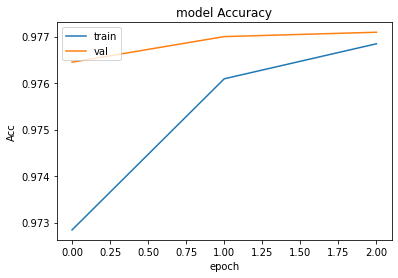

In [44]:
plt.plot(np.sqrt(accs))
plt.plot(np.sqrt(accs_eval))
plt.title('model Accuracy')
plt.ylabel('Acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [97]:
preds = []
targets = []
for texts, ys in valid_generator:
    preds += model(texts.to(device)).squeeze().detach().to('cpu').numpy().tolist()
    targets += ys.numpy().tolist()

Можно вытащить предикты и посчитать все через sklearn

In [99]:
from sklearn.metrics import classification_report

In [101]:
# можно подбирать порог для отнесения к токсичному классу
print(classification_report(targets, (np.array(preds) > 0.5).astype(int)))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     61330
         1.0       0.67      0.47      0.55      3977

    accuracy                           0.95     65307
   macro avg       0.82      0.73      0.76     65307
weighted avg       0.95      0.95      0.95     65307



## Домашка

1) На одной из задач сравните, что лучше: а) конкатенировать эмбединги в один большой эмбединг, б) усреднять эмбединги, в) складывать эмбединги. Зафиксируйте разбиение на train_test  через random_seed, чтобы обучаться и оцениваться на одних и тех же данных. Параметры нейронок не нужно делать одинаковыми. Просто попробуйте добиться максимума от каждого из подходов. 

2) В одной из задач используйте сразу две предобученные эмбединг модели (можно фастекст и ворд2век, а можно просто 2 фастекста с разными параметрами) в одной нейронке (имеется в виду предобученные до обучения нейронки, т.е вы можете сами обучить фастекст/ворд2век и не искать готовые модели в интернете). Попробуйте усреднять эмбединги и конкатенировать (общие эмбединги потом в один вектор собирайте любым способом - например, тем который оказался лучше в первой задаче).
Подсказка: сделайте два Embedding слоя и к их выходам примените torch.cat(dim=2) или torch.mean(dim=2)


Бонусный балл можно получить за добавление к пайплайну subword токенизации (через библиотеку tokenizers например)

Лучше делать задание на второй задаче, так как в Авито в любом случае разница будет в несколько десятых процентов.